In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from causalinference import CausalModel
from sklearn.linear_model import LogisticRegression


import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

## Key ideas
The probability of getting the treatment is called the propensity score and that we can use this as a balancing score. 
Also we can combine linear regression and propensity score to obtain a more robust estimator.

In [3]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


In [5]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


The treated group has an achievement score that is, on average, 0.3185 (0.4723 - 0.1538) higher than the average score (which is zero, since the score is standardized).

In [6]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


# Compute propensity scores which is the probability to receive the treatment

In [11]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score=ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head()

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315496
1,1,-0.449646,0.263789
2,1,0.769703,0.344029
3,1,-0.121763,0.344029
4,1,1.526147,0.367797


Check if propensity scores recover a population where everyone is treated.

In [13]:
print("Original Sample Size", data.shape[0])

Original Sample Size 10391


In [21]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Treated Population Sample Size 10388.443755049593
Untreated Population Sample Size 10391.482074447029


Different propensity scores same across segments of the population are different indicating the presence of confounders.

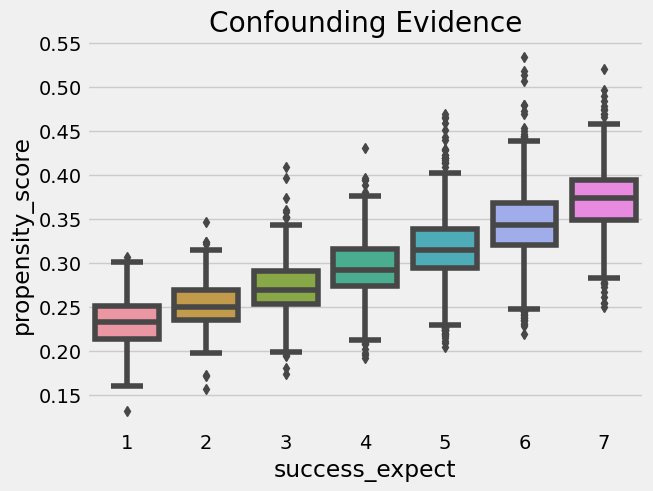

In [23]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

We have to check that there is an overlap between the treated and untreated population

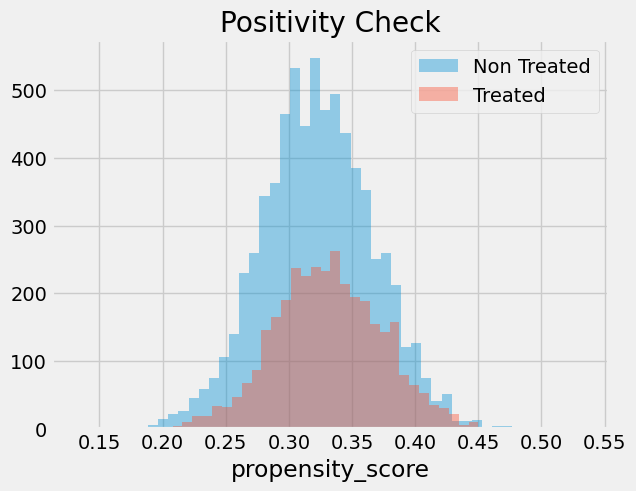

In [24]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

$
\text{ATE} = E\bigg[Y \dfrac{T-P(x)}{P(x)(1-P(x))}\bigg]
$


In [26]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

ate = np.mean(weight * data_ps["achievement_score"])

print("ATE", np.mean(weight * data_ps["achievement_score"]))

ATE 0.3885209216143152


Contrast this to the 0.47 ATE estimate we’ve got by simply comparing treated and untreated. This is evidence that the bias we have is indeed positive and that controlling for X gives us a more modest estimate of the impact of the growth mindset.



To compute the standard error for IPTW estimator, we use the formula of the variance of a weighted average:
$
\sigma^2_w = \dfrac{\sum_{i=1}^{n}w_i(y_i-\hat{\mu})^2}{\sum_{i=1}^{n}w_i}
$
    

However we do not have the true propensity score, we will use bootstrapping procedure and sampling with replacement from the original data and computing the ATE like we did above. 
We then repeat this many times to get the distribution of the ATE estimate.

In [34]:
def run_ps(df, X, T, y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    weight = (df["intervention"]-ps) / (ps*(1-ps))
    return np.mean(weight * df["achievement_score"])

In [35]:
from joblib import Parallel, delayed # for parallel processing
np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

The ATE is then the mean of the bootstrap samples. 
To get confidence intervals, we can inspect the quantiles of the bootstrap distribution. 
For the 95% C.I., we use the 2.5 and 97.5 percentiles.

In [36]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.3877462063444846
95% C.I.: (0.35451528468689003, 0.4199256000572739)


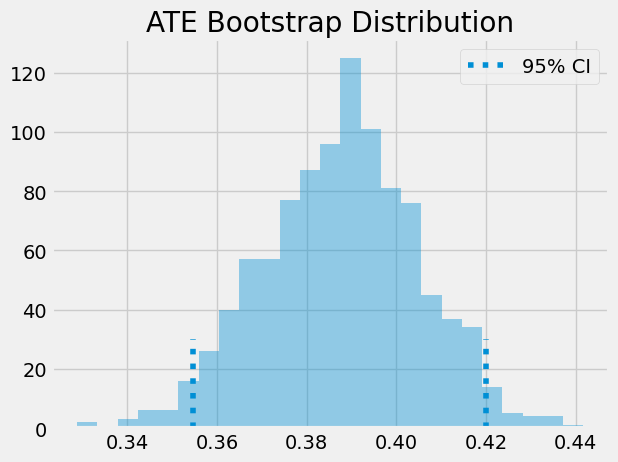

In [37]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

# Propensity score matching

We will match population on the ps itself instead of features X which avoids matching on unimportant features.
If a feature is unimportant for the treatment assignment, its ps is low and the ps score model will learn it and
will give low importance.

In [38]:
cm = CausalModel(
    Y=data_ps["achievement_score"].values, 
    D=data_ps["intervention"].values, 
    X=data_ps[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.403      0.025     16.118      0.000      0.354      0.452
           ATC      0.394      0.027     14.361      0.000      0.341      0.448
           ATT      0.421      0.027     15.811      0.000      0.368      0.473



# Doubly Robust Estimation

The idea is to combine linear regression with the propensity score to produce a more robust estimator.
$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

Consider
$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
\\
$ 
If $\hat{\mu_1}(x)$ is correct but ps is incorrect then
$E[T_i(Y_i - \hat{\mu_1}(X_i))]= T_i (E[Y_i] - \hat{\mu_1}) = 0$
and $
\\
\hat{E}[Y_1] = \hat{\mu_1}(X_i) 
$
We can apply the same reasoning to $\hat{E}[Y_0]$ 

In [43]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [44]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822174941527776

In [45]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [46]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: 0.38735182875566965
95% C.I.: (0.35365381851525274, 0.41978398834412084)


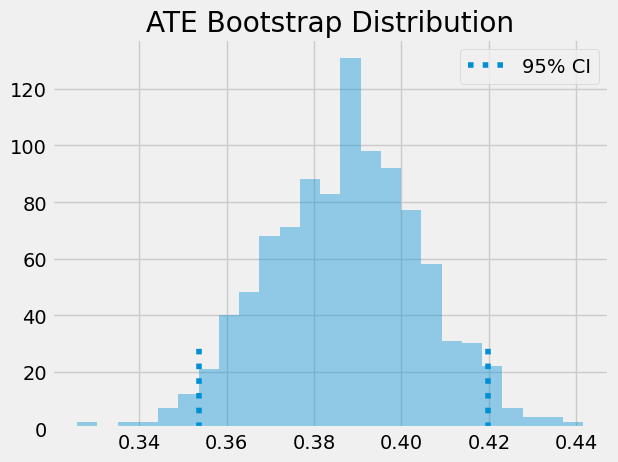

In [47]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();